# Building a Handwritten Digits Classifier with Neural Networks
by Nicholas Archambault

Deep neural networks have been used to reach state-of-the-art performance on image classification tasks in the last decade. For some image classification tasks, deep neural networks actually perform as well as or slightly better than the human benchmark.

This project will explore the effectiveness of deep, feedforward neural networks at classifying images of digits.

## Importing the Data

We'll first import the appropriate packages as well as a pre-loaded Python dataset of handwritten digits from the University of California - Irvine and transform the resulting 2D array of data values into a Pandas dataframe.

In [1]:
from sklearn.datasets import load_digits
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
digits_data = load_digits()
digits_data.keys()

dict_keys(['data', 'target', 'target_names', 'images', 'DESCR'])

In [3]:
# Convert key aspects to series and dataframe objects
labels = pd.Series(digits_data["target"])
data = pd.DataFrame(digits_data["data"])

After this transformation, each image is represented as a row of pixel values. We'll need to reshape the image to its original 28x28 pixel format and plot it on a coordinate grid in order to visualize it.

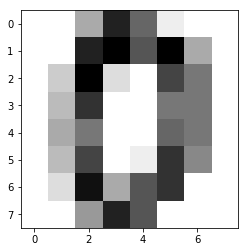

In [4]:
first_image = data.iloc[0]
np_image = first_image.values
np_image = np_image.reshape(8,8)

plt.imshow(np_image, cmap="gray_r")

We can plot multiple images on the same grid in order to get a sense of their varied appearances.

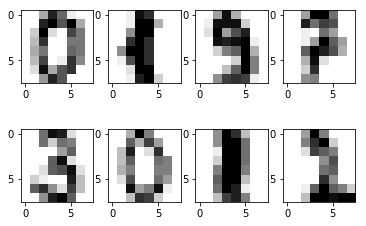

In [5]:
fig, ax = plt.subplots(2,4)

ax[0,0].imshow(data.iloc[0].values.reshape(8,8), cmap="gray_r")
ax[0,1].imshow(data.iloc[99].values.reshape(8,8), cmap="gray_r")
ax[0,2].imshow(data.iloc[199].values.reshape(8,8), cmap="gray_r")
ax[0,3].imshow(data.iloc[299].values.reshape(8,8), cmap="gray_r")

ax[1,0].imshow(data.iloc[999].values.reshape(8,8), cmap="gray_r")
ax[1,1].imshow(data.iloc[1099].values.reshape(8,8), cmap="gray_r")
ax[1,2].imshow(data.iloc[1199].values.reshape(8,8), cmap="gray_r")
ax[1,3].imshow(data.iloc[1299].values.reshape(8,8), cmap="gray_r")

## K-Nearest Neighbors Model

Our baseline model uses a k-nearest neighbors algorithm; we establish a data pipeline to create, test, and establish the model's accuracy with 4-fold cross validation.

In [6]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold

## FUNCTION PIPELINE

# Training function; renders 50/50 train/test split of data
def train(neighbors, train_features, train_labels):
    knn = KNeighborsRegressor(n_neighbors = neighbors)
    knn.fit(train_features, train_labels)
    return knn

# Testing function
def test(model, test_features, test_labels):
    predictions = model.predict(test_features)
    train_test_df = pd.DataFrame()
    train_test_df["correct_labels"] = test_labels
    train_test_df["predictions"] = predictions
    accuracy = sum(train_test_df["correct_labels"] == train_test_df["predictions"])/len(train_test_df)
    
    return accuracy

# 4-fold cross validation of testing results
def cross_validate(k):
    fold_accuracies = []
    kf = KFold(n_splits = 4, random_state = 2)
    for train_index, test_index in kf.split(data):
        train_features, test_features = data.loc[train_index], data.loc[test_index]
        train_labels, test_labels = labels.loc[train_index], labels.loc[test_index]
        
        model = train(k, train_features, train_labels)
        accuracy = test(model, test_features, test_labels)
        fold_accuracies.append(accuracy)
        
    return fold_accuracies

# Run pipeline for model with k = 1
knn_one = cross_validate(1)

# Must take mean of cross-validated accuracies
np.mean(knn_one)

0.9677233358079684

With a k-value of 1 and 4-fold cross validation, our model yields a respectable accuracy value of 96.8%.

We can then establish a range of values for k and run the model and plot the results for each.

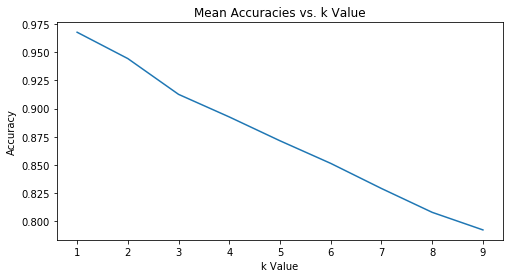

In [7]:
# Update parameters
k_values = list(range(1,10))
k_accuracies = []

# Enfold into model pipeline
for k in k_values:
    accuracy = cross_validate(k)
    mean_accuracy = np.mean(accuracy)
    k_accuracies.append(mean_accuracy)
    
plt.figure(figsize = (8,4))
plt.plot(k_values, k_accuracies)
plt.title("Mean Accuracies vs. k Value")
plt.xlabel("k Value")
plt.ylabel("Accuracy")
plt.show()

We can see from the plot that a k-nearest neighbors model with 4-fold cross validation generally yields diminishing accuracy as k is increased. The most accurate model features a k-value of 1.

We will use neural networks with increasing numbers of hidden layers to generate more accurate models.

# Single Layer Neural Network

The power of neural networks lies in their ability to construct and learn from intermediate stage models within hidden layers. We'll test a single-layer network to gauge its comparison in accuracy to the k-nearest neighbors model.

The data pipeline remains largely the same aside from the replacement of the k-nearest neighbors estimator object with a neural network object from scikit Learn's `neural_network.MLPClassifier` class. We iterate over an array of values for neuron quantities within the single hidden layer (8, 16, 32, 64, 128, 256) and continue to use 4-fold cross validation to assess the accuracy of each iteration, plotting the results.

In [8]:
# Import packages
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold

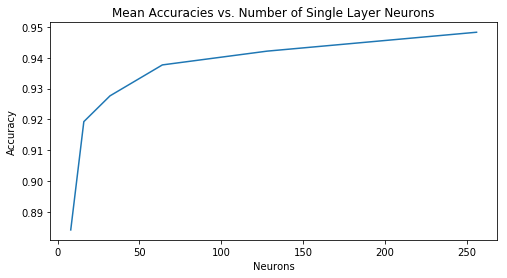

In [9]:
## FUNCTION PIPELINE

# Neural network training function
def train_nn(neural_arch, train_features, train_labels):
    nn = MLPClassifier(hidden_layer_sizes = neural_arch, max_iter = 10000)
    nn.fit(train_features, train_labels)
    return nn

# Testing function
def test_nn(model, test_features, test_labels):
    predictions = model.predict(test_features)
    train_test_df = pd.DataFrame()
    train_test_df["correct_labels"] = test_labels
    train_test_df["predictions"] = predictions
    accuracy = sum(train_test_df["correct_labels"] == train_test_df["predictions"])/len(train_test_df)
    
    return accuracy

# Cross-validation function
def cross_validate_nn(neural_arch):
    fold_accuracies = []
    kf = KFold(n_splits = 4, random_state = 2)
    for train_index, test_index in kf.split(data):
        train_features, test_features = data.loc[train_index], data.loc[test_index]
        train_labels, test_labels = labels.loc[train_index], labels.loc[test_index]
        
        model = train_nn(neural_arch, train_features, train_labels)
        accuracy = test_nn(model, test_features, test_labels)
        fold_accuracies.append(accuracy)
        
    return fold_accuracies

# Define list of neural parameters
neural_layers = [
    (8,),
    (16,),
    (32,),
    (64,),
    (128,),
    (256,)
]

neural_accuracies = []

# Iterate through neural parameters, resulting in list of comparative accuracies
for n in neural_layers:
    accuracy = cross_validate_nn(n)
    mean_accuracy = np.mean(accuracy)
    neural_accuracies.append(mean_accuracy)

x = [i[0] for i in neural_layers]

plt.figure(figsize = (8,4))
plt.plot(x, neural_accuracies)
plt.title("Mean Accuracies vs. Number of Single Layer Neurons")
plt.xlabel("Neurons")
plt.ylabel("Accuracy")
plt.show()

In [10]:
neural_accuracies

[0.8842514229151199,
 0.9193046275674339,
 0.9276540460282108,
 0.9376676565206633,
 0.9421244741400645,
 0.9482417718386538]

From the plot, we see that a greater number of neurons generally leads to a more accurate model: the iteration with 256 neurons achieved close to 95% accuracy, up from the ~88% accuracy achieved by the model with only 8 neurons. Simple accuracy computes the number of correct classifications the model made, but doesn't tell us anything about false or true positives or false or true negatives, meaning these better-fitting models could actually be overfitting.

Given that the k-nearest neighbors model achieved over 96% accuracy, there seem to be no advantages to using a single layer neural network instead.

## Double Layer Network

We can alter the model so it takes two identical hidden layers of 64, 128 and 256 neurons.

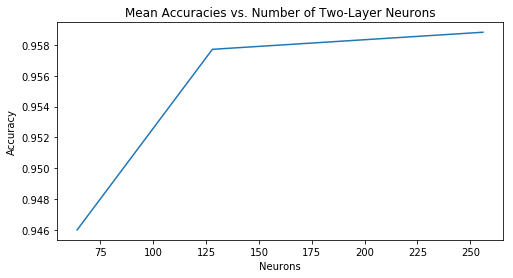

In [11]:
# Alter neural parameters
neural_layers_two = [
    (64,64),
    (128,128),
    (256,256)
]

neural_accuracies_two = []

# Run function pipeline for new parameters
for n in neural_layers_two:
    accuracy = cross_validate_nn(n)
    mean_accuracy = np.mean(accuracy)
    neural_accuracies_two.append(mean_accuracy)

x = [i[0] for i in neural_layers_two]

plt.figure(figsize = (8,4))
plt.plot(x, neural_accuracies_two)
plt.title("Mean Accuracies vs. Number of Two-Layer Neurons")
plt.xlabel("Neurons")
plt.ylabel("Accuracy")
plt.show()

In [12]:
neural_accuracies_two

[0.9460146003464489, 0.957706013363029, 0.9588121752041574]

Using two layers marginally improved accuracy. We should be wary of overfitting, but using 4-fold cross validation also provides a bit more assurance that the model is generalizing to achieve the extra 1% in simple accuracy over the single hidden layer networks we tried earlier.

## Triple Layer Network

To help prevent overfitting, we can increase the validation to 6-fold as we incorporate a third hidden layer. Neuron values are 10, 64, and 128.

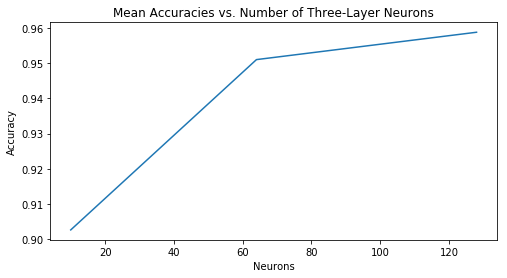

In [13]:
# Modify function to use 6-fold cross-validation
def cross_validate_nn(neural_arch):
    fold_accuracies = []
    kf = KFold(n_splits = 6, random_state = 2)
    for train_index, test_index in kf.split(data):
        train_features, test_features = data.loc[train_index], data.loc[test_index]
        train_labels, test_labels = labels.loc[train_index], labels.loc[test_index]
        
        model = train_nn(neural_arch, train_features, train_labels)
        accuracy = test_nn(model, test_features, test_labels)
        fold_accuracies.append(accuracy)
        
    return fold_accuracies

# Three-layer network list
neural_layers_three = [
    (10,10,10),
    (64,64,64),
    (128,128,128)
]

neural_accuracies_three = []

# Run function pipeline
for n in neural_layers_three:
    accuracy = cross_validate_nn(n)
    mean_accuracy = np.mean(accuracy)
    neural_accuracies_three.append(mean_accuracy)

x = [i[0] for i in neural_layers_three]

plt.figure(figsize = (8,4))
plt.plot(x, neural_accuracies_three)
plt.title("Mean Accuracies vs. Number of Three-Layer Neurons")
plt.xlabel("Neurons")
plt.ylabel("Accuracy")
plt.show()

In [14]:
neural_accuracies_three

[0.9026142697881828, 0.9510330732069862, 0.9588127090301004]

## Conclusion

Using three hidden layers improved accuracy to nearly 96%, even with 6-fold cross validation and only 128 neurons. This seems to be in line with the research literature out there about deep neural networks for computer vision. Having more layers and more neurons tends to improve the network's performance.